# Direct Arylation

*Out of sample prediction.* In this work we emphasized the use of structure-based reaction encodings because they enable the selection of components based on molecular similarity, should facilitate out of sample prediction, and support mechanistic inference. In particular, when selecting the ligands we utilized unsupervised learning to group ligands based on computed similarity and then selected from amongst the groups to ensure a satisfactory distribution of ligands across the larger space. While not the focus of this work, we were curious to see if models trained with the resulting data set would be effective in predicting ligands which were not in the training data (out of sample prediction). Thus, we collected HTE data for 2 additional ligands to be used as an out of sample validation and test set.

## Imports

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
import numpy as np

import sys_path
from Data import direct_arylation, direct_arylation_extended, Data
from chem_utils import ChemDraw

import matplotlib.pyplot as plt
import matplotlib


RDKit WARNING: [12:27:28] Enabling RDKit 2019.09.1 jupyter extensions


## Data

### OHE

In [2]:
# Initial 12 ligands
arylation1 = Data(direct_arylation(base='ohe', ligand='ohe', solvent='ohe'))

# New ligands
arylation2 = Data(direct_arylation_extended(base='ohe', ligand='ohe', solvent='ohe'))

# Pad OHE data so they can be merged

def ligand_columns(arylation):
    """Get ligand columns."""
    cols = []
    for c in arylation:
        if 'ligand' in c:
            cols.append(c)

    return cols

def pad_ohe(df1, df2):
    """
    Pad OHE data in df1 with new columns from df2
    so they can be merged.
    """
    
    # Get ligand columns
    ligand_cols1 = ligand_columns(df1.drop('ligand_SMILES', axis=1).columns.values)
    ligand_cols2 = ligand_columns(df2.drop('ligand_SMILES', axis=1).columns.values)
    
    # Build zero matrix
    zeros = [np.zeros(len(ligand_cols2)) for i in range(len(df1))]
    df3 = pd.DataFrame(zeros, columns=ligand_cols2)
    
    # Concatinate
    return pd.concat([df1, df3], sort=False, axis=1)

df1 = pad_ohe(arylation1.data, arylation2.data)
df2 = pad_ohe(arylation2.data, arylation1.data)

# Merge the data sets
full = Data(pd.concat([df1, df2], sort=False).dropna(axis=1).reset_index(drop=True))

# Remove unwanted columns
full.data = full.base_data
full.clean()
full.drop(['entry'])
    
# Standardize
full.standardize(scaler='minmax')

# SMILES
old_ligands = arylation1.base_data['ligand_SMILES'].drop_duplicates().values
new_ligands = arylation2.base_data['ligand_SMILES'].drop_duplicates().values

# Get corresponding entries
def get_data(smiles):
    """Get indices from SMILES strings from DataFrame. Then get the corresponding data."""

    index = list(arylation2.base_data[arylation2.base_data['ligand_SMILES'] == smiles]['entry'].values)
        
    return full.data.iloc[index]

# Training and test sets
full_ohe = full.data
training_ohe = full.data.iloc[arylation1.data.index.values]
test1_ohe = get_data(new_ligands[0])
test2_ohe = get_data(new_ligands[1])

### Mordred

In [3]:
# Initial 12 ligands
arylation1 = Data(direct_arylation(base='mordred', ligand='mordred', solvent='mordred'))

# New ligands
arylation2 = Data(direct_arylation_extended(base='mordred', ligand='mordred', solvent='mordred'))

# Merge the data sets
full = Data(pd.concat([arylation1.data, arylation2.data], sort=False).dropna(axis=1).reset_index(drop=True))

# Remove unwanted columns
full.data = full.base_data
full.clean()
full.drop(['entry'])
    
# Standardize
full.standardize(scaler='minmax')
   
# Drop highly correlated features
full.uncorrelated(threshold=0.95)

# SMILES
old_ligands = arylation1.base_data['ligand_SMILES'].drop_duplicates().values
new_ligands = arylation2.base_data['ligand_SMILES'].drop_duplicates().values

# Get corresponding entries
def get_data(smiles):
    """Get indices from SMILES strings from DataFrame. Then get the corresponding data."""

    index = list(arylation2.base_data[arylation2.base_data['ligand_SMILES'] == smiles]['entry'].values)
        
    return full.data.iloc[index]

# Training and test sets
full_mordred = full.data
training_mordred = full.data.iloc[arylation1.data.index.values]
test1_mordred = get_data(new_ligands[0])
test2_mordred = get_data(new_ligands[1])

### DFT

In [4]:
# Initial 12 ligands
arylation1 = Data(direct_arylation(base='dft', ligand='boltzmann-dft', solvent='dft'))

# New ligands
arylation2 = Data(direct_arylation_extended(base='dft', ligand='boltzmann-dft', solvent='dft'))

# Merge the data sets
full = Data(pd.concat([arylation1.data, arylation2.data], sort=False).dropna(axis=1).reset_index(drop=True))

# Remove unwanted columns
full.data = full.base_data
full.clean()
full.drop(['entry', 'vibration', 'correlation', 'Rydberg', 'correction', 
          'atom_number', 'E-M_angle', 'MEAN'])
    
# Standardize
full.standardize(scaler='minmax')
   
# Drop highly correlated features
full.uncorrelated(threshold=0.95)

# SMILES
old_ligands = arylation1.base_data['ligand_SMILES'].drop_duplicates().values
new_ligands = arylation2.base_data['ligand_SMILES'].drop_duplicates().values

# Get corresponding entries
def get_data(smiles):
    """Get indices from SMILES strings from DataFrame. Then get the corresponding data."""

    index = list(arylation2.base_data[arylation2.base_data['ligand_SMILES'] == smiles]['entry'].values)
        
    return full.data.iloc[index]

# Training and test sets
full_dft = full.data
training_dft = full.data.iloc[arylation1.data.index.values]
test1_dft = get_data(new_ligands[0])
test2_dft = get_data(new_ligands[1])

## Modeling

In [8]:
# Imports

from torch_utils import cv_split
from bro import BO
from models import GP_Model, RF_Model
from pd_utils import to_torch
from plot_utils import pred_obs
from math_utils import model_performance

from gpytorch.priors import GammaPrior as Gamma

# Functions

def mode(concentration, rate):
    """
    Compute mode of Gamma distribution to be used as
    initial values in hyperparameter optimization.
    """
    
    return round((concentration - 1) / rate,5)

def out_of_sample_preformance(encoding, domain, training, test1, test2, lsp, osp, npr):
    
    models = [GP_Model, RF_Model]
    names = ['GP', 'RF']
    predobs = []

    for model, name in zip(models, names):
    
        # Use BO object direclty for modeling
        bo = BO(domain=domain,
                results=training, 
                model=model,
                acquisition_function='rand', 
                batch_size=1,
                lengthscale_prior=lsp,
                outputscale_prior=osp,
                noise_prior=npr)
        
        # Train
        bo.run()
    
        # Predictions
        pred1 = bo.obj.scaler.unstandardize(np.array(bo.model.predict(to_torch(test1.drop('yield', axis=1)))))
        obs1 = test1['yield'].values
        pred_obs(pred1, 
                 obs1, 
                 title=name + '|$P(Ph)_2Cy$|' + encoding,
                 export_path = 'direct_arylation_out_of_sample/' + name + '_P(Ph)2Cy_' + encoding)

        pred2 = bo.obj.scaler.unstandardize(np.array(bo.model.predict(to_torch(test2.drop('yield', axis=1)))))
        obs2 = test2['yield'].values
        pred_obs(pred2, 
                 obs2, 
                 title=name + '|Cy-JohnPhos|' + encoding,
                 export_path = 'direct_arylation_out_of_sample/' + name + '_Cy-JohnPhos_' + encoding)
    
        # Save results
        predobs.append([[pred1, obs1], [pred2, obs2]])
    
    return predobs

### OHE

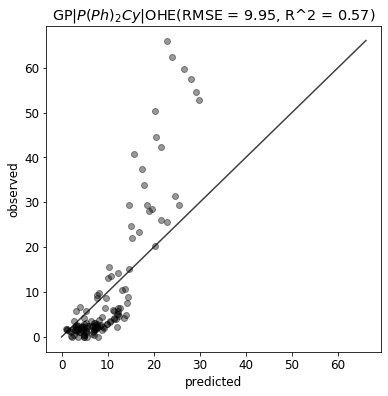

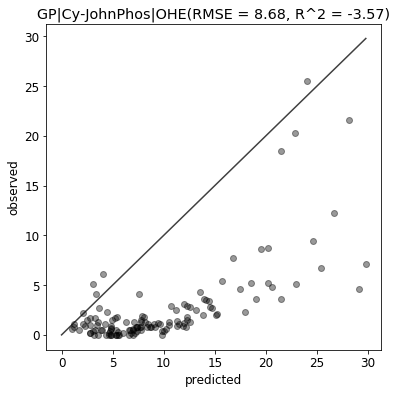

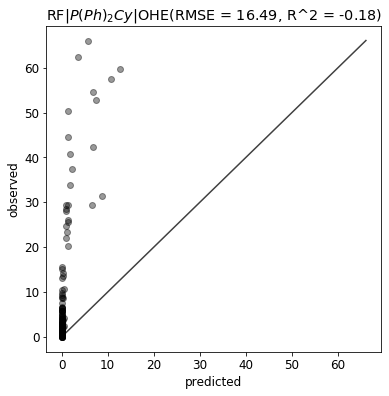

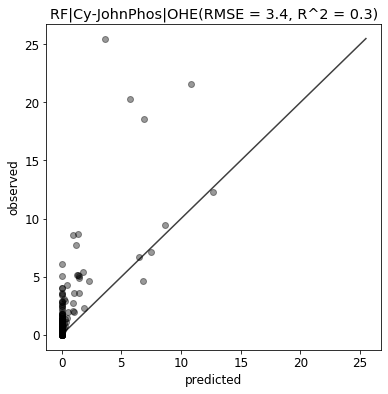

In [11]:
encoding = 'OHE'
domain = full_ohe.drop('yield', axis=1)
training = training_ohe
test1 = test1_ohe
test2 = test2_ohe
lsp = [Gamma(3, 1), mode(3, 1)]
osp = [Gamma(5, 0.2), mode(5, 0.2)]
npr = [Gamma(1.5, 0.1), mode(1.5, 0.1)]

predobs_ohe = out_of_sample_preformance(encoding, domain, training, test1, test2, lsp, osp, npr)

### Mordred

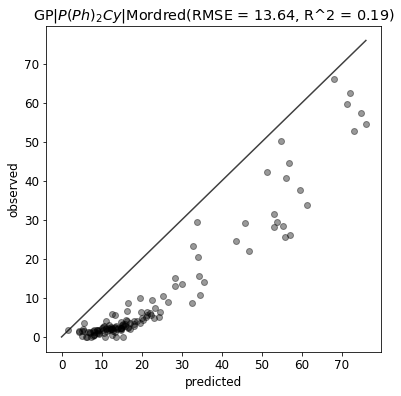

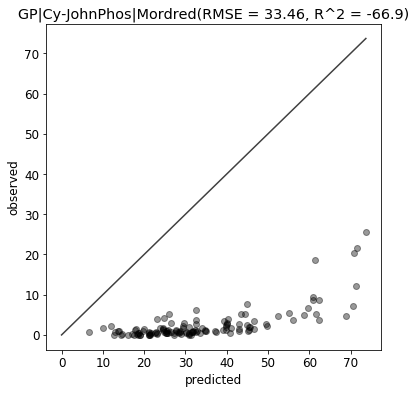

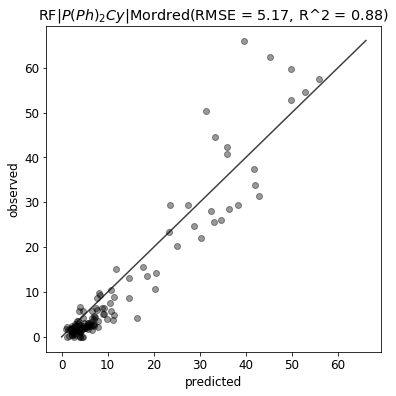

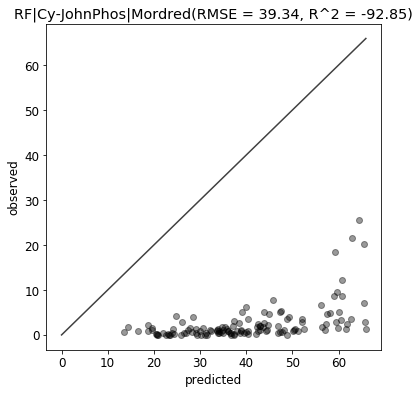

In [9]:
encoding = 'Mordred'
domain = full_mordred.drop('yield', axis=1)
training = training_mordred
test1 = test1_mordred
test2 = test2_mordred
lsp = [Gamma(2, 0.1), mode(2, 0.1)]
osp = [Gamma(2, 0.1), mode(2, 0.1)]
npr = [Gamma(1.5, 0.1), mode(1.5, 0.1)]

predobs_mordred = out_of_sample_preformance(encoding, domain, training, test1, test2, lsp, osp, npr)

### DFT

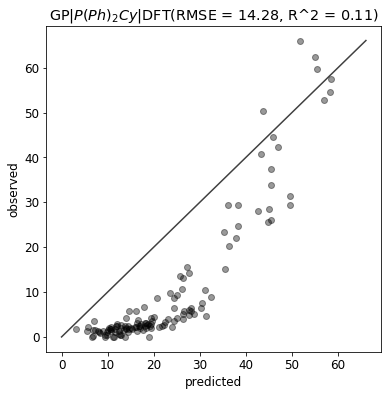

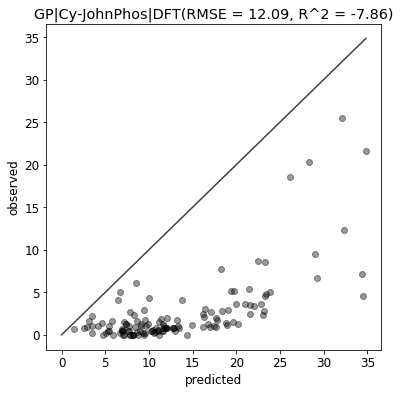

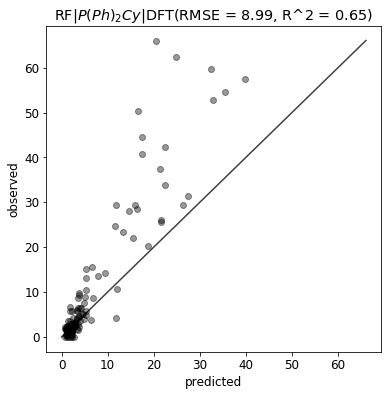

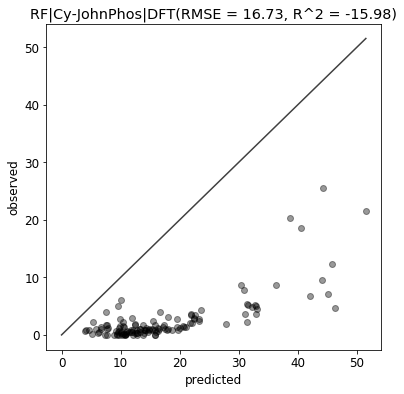

In [12]:
encoding = 'DFT'
domain = full_dft.drop('yield', axis=1)
training = training_dft
test1 = test1_dft
test2 = test2_dft
lsp = [Gamma(2, 0.2), mode(2, 0.2)]
osp = [Gamma(5, 0.5), mode(5, 0.5)]
npr = [Gamma(1.5, 0.5), mode(1.5, 0.5)]

predobs_dft = out_of_sample_preformance(encoding, domain, training, test1, test2, lsp, osp, npr)

## Summary

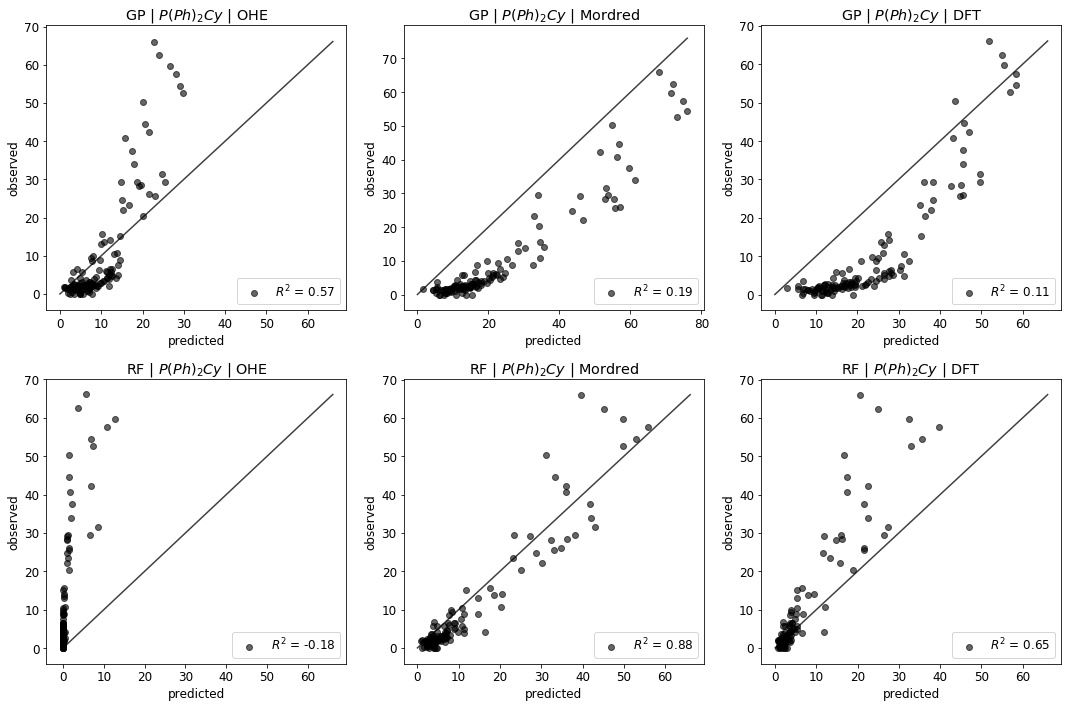

In [36]:
def scatter(ax, pred, obs, plot_label=''):
    """
    Scatter plot with y=x line.
    """
    upper = max([max(pred), max(obs)])
    lower = min([min(pred), min(obs)])
    
    rmse, r2 = model_performance(pred, obs)
    
    ax.plot([lower,upper], [lower,upper], 'k-', alpha=0.75, zorder=0)
    ax.scatter(np.array(pred), np.array(obs), color='black', alpha=0.6, label='$R^2$ = ' + str(round(r2,2)))
    ax.set_xlabel('predicted')
    ax.set_ylabel('observed')
    ax.set_title(plot_label)
    ax.legend(loc='lower right')
    fig.tight_layout()

fig, ax = plt.subplots(2, 3, figsize=(15,10))

scatter(ax[0][0], predobs_ohe[0][0][0], predobs_ohe[0][0][1], plot_label='GP | $P(Ph)_2Cy$ | OHE')
scatter(ax[0][1], predobs_mordred[0][0][0], predobs_mordred[0][0][1], plot_label='GP | $P(Ph)_2Cy$ | Mordred')
scatter(ax[0][2], predobs_dft[0][0][0], predobs_dft[0][0][1], plot_label='GP | $P(Ph)_2Cy$ | DFT')

scatter(ax[1][0], predobs_ohe[1][0][0], predobs_ohe[1][0][1], plot_label='RF | $P(Ph)_2Cy$ | OHE')
scatter(ax[1][1], predobs_mordred[1][0][0], predobs_mordred[1][0][1], plot_label='RF | $P(Ph)_2Cy$ | Mordred')
scatter(ax[1][2], predobs_dft[1][0][0], predobs_dft[1][0][1], plot_label='RF | $P(Ph)_2Cy$ | DFT')

plt.savefig('direct_arylation_out_of_sample/P(Ph)2Cy.svg', format='svg', dpi=1200, bbox_inches='tight')
plt.show()

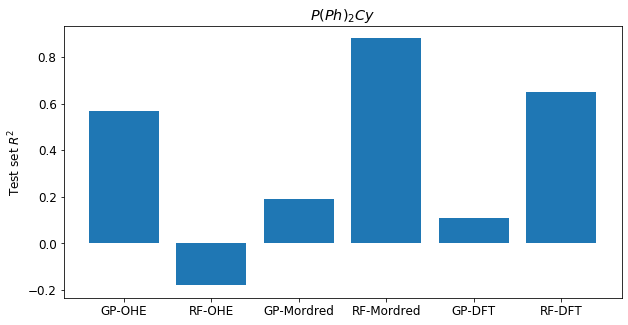

In [59]:
x = ['GP-OHE', 'RF-OHE', 'GP-Mordred', 'RF-Mordred', 'GP-DFT', 'RF-DFT']
r2s = [0.57, -0.18, 0.19, 0.88, 0.11, 0.65]

x_pos = [i for i, _ in enumerate(x)]

fig, ax = plt.subplots(1, figsize=(10,5))
plt.bar(x_pos, r2s)
plt.xlabel('')
plt.ylabel('Test set $R^2$')
plt.title('$P(Ph)_2Cy$')
plt.xticks(x_pos, x)

plt.savefig('direct_arylation_out_of_sample/P(Ph)2Cy_summary_bar.svg', format='svg', dpi=1200, bbox_inches='tight')
plt.show()

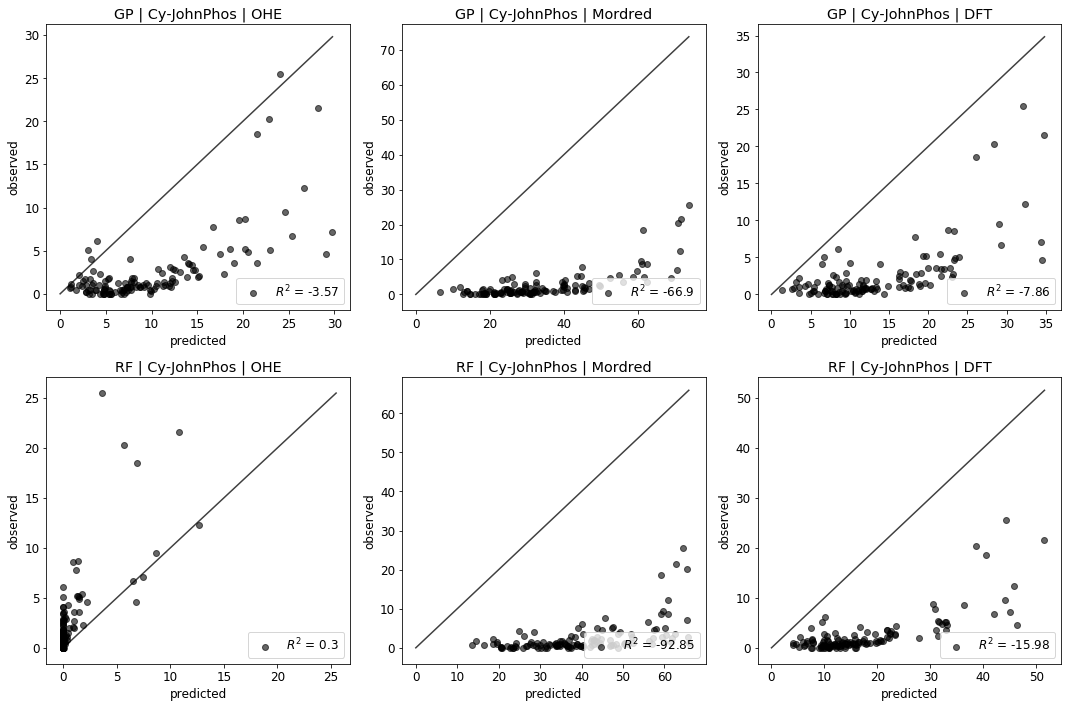

In [35]:
fig, ax = plt.subplots(2, 3, figsize=(15,10))

scatter(ax[0][0], predobs_ohe[0][1][0], predobs_ohe[0][1][1], plot_label='GP | Cy-JohnPhos | OHE')
scatter(ax[0][1], predobs_mordred[0][1][0], predobs_mordred[0][1][1], plot_label='GP | Cy-JohnPhos | Mordred')
scatter(ax[0][2], predobs_dft[0][1][0], predobs_dft[0][1][1], plot_label='GP | Cy-JohnPhos | DFT')

scatter(ax[1][0], predobs_ohe[1][1][0], predobs_ohe[1][1][1], plot_label='RF | Cy-JohnPhos | OHE')
scatter(ax[1][1], predobs_mordred[1][1][0], predobs_mordred[1][1][1], plot_label='RF | Cy-JohnPhos | Mordred')
scatter(ax[1][2], predobs_dft[1][1][0], predobs_dft[1][1][1], plot_label='RF | Cy-JohnPhos | DFT')

plt.savefig('direct_arylation_out_of_sample/Cy-JohnPhos.svg', format='svg', dpi=1200, bbox_inches='tight')
plt.show()

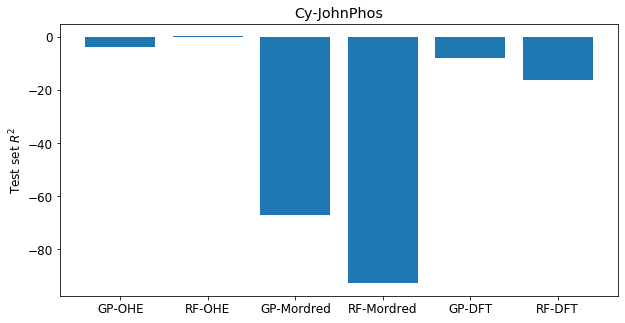

In [60]:
x = ['GP-OHE', 'RF-OHE', 'GP-Mordred', 'RF-Mordred', 'GP-DFT', 'RF-DFT']
r2s = [-3.57, 0.3, -66.9, -92.8, -7.86, -15.98]

x_pos = [i for i, _ in enumerate(x)]

fig, ax = plt.subplots(1, figsize=(10,5))
plt.bar(x_pos, r2s)
plt.xlabel('')
plt.ylabel('Test set $R^2$')
plt.title('Cy-JohnPhos')
plt.xticks(x_pos, x)

plt.savefig('direct_arylation_out_of_sample/Cy-JohnPhos_summary_bar.svg', format='svg', dpi=1200, bbox_inches='tight')
plt.show()